# Adoption of the Replying Tool (Beta Features)

[Task](https://phabricator.wikimedia.org/T249386)

June 2020

# Contents
1. [How many people have used the Reply tool?](#How-many-people-have-used-the-Reply-tool?)
2. [How often are people using the Reply tool to make talk page edits?](#How-often-are-people-using-the-Reply-tool-to-make-talk-page-edits?)
3. [How many people have had access to the Reply tool? ](#How-many-people-have-had-access-to-the-Reply-tool?)
4. [How many people should we expect to try the Replying feature when it is turned on as an opt out user preference at our four partner wikis?](#How-many-people-should-we-expect-to-try-the-Replying-feature-when-it-is-turned-on-as-an-opt-out-user-preference-at-our-four-partner-wikis?)
5. [How many talk page edits are being made with the Reply Tool?](#How-many-talk-page-edits-are-being-made-with-the-Reply-Tool?) 
6. [What is the experience of Reply Tool Users? In Progress](#What-is-the-experience-of-Reply-Tool-Users?-In-Progress)

# Background

In [T244872](https://phabricator.wikimedia.org/T244872) and [T245794](https://phabricator.wikimedia.org/T245794) the reply tool was released as an opt-in beta feature for the following partner wikis: Arabic, Dutch, French and Hungarian. Version 1.0 of the replying tool was deployed on to the partner wikis on March 31, 2020 and Version 2.0 was deployed on June 17, 2020.

We would like to know how the tool is being used and adopted by the partner wikis as a Beta Feature prior to deploying the  tool to all volunteers as an opt-out preference on the four partner wikis [T249394](https://phabricator.wikimedia.org/T249394).

# Data

Data for this analysis comes from the [PrepUpdate](https://meta.wikimedia.org/wiki/Schema:PrefUpdate) table, the [user properties](https://www.mediawiki.org/wiki/Manual:User_properties_table/en) table, and [mediawiki_history](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Edits/MediaWiki_history) table. 

For metrics that were calculated using mediawiki_history, we reviewed data from the release of Version 1.0 on March 31 through the end of June 2020 (the most recent data available at the time of this analysis).


In [382]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [21]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse); library(glue); library(lubridate); library(scales)
})

# How many people have used the Reply tool? 

Notes: 
- We reviewed the number and percentage of people overall and by that made just 1 edit and that made edits within identified buckets (e.g. " E.g. "1-5 edits," "6-10 edits," etc.
- Data comes from mediawiki_history using the new change tag implemented in [T242184](https://phabricator.wikimedia.org/T242184). 
- We reviewed all edits made with the discussiontools tag. These include all users who were able to successfully make an edit using the reply tool. It does not include attempts with the tool that were not saved. 
- Any self-identified bots were filtered out from the data; however, some un-identified bots might still be included.

In [ ]:
# Collect users max reply edits over time period and remove bots

query <- "

SELECT
    wiki,
    reply_user,
    max(reply_edits) as reply_edit_count
FROM (
    SELECT
        wiki_db AS wiki,
        event_user_id as reply_user,
        max(size(event_user_is_bot_by) > 0 or size(event_user_is_bot_by_historical) > 0) as bot_by_group,
        Count(*) as reply_edits
FROM wmf.mediawiki_history
WHERE 
    ARRAY_CONTAINS(revision_tags, 'discussiontools') AND
    snapshot = '2020-06' AND
    event_timestamp >= '2020-03-31' AND 
    event_timestamp <= '2020-06-30' AND
    wiki_db IN ('arwiki','nlwiki', 'frwiki', 'huwiki') AND
    event_entity = 'revision' AND
    event_type = 'create'
GROUP BY
    wiki_db,
    event_user_id  
) edits
WHERE not bot_by_group
GROUP BY reply_user, wiki"

results <- collect(sql(query))
save(results, file="Data/reply_edit_users.RData")

In [205]:
load("Data/reply_edit_users.RData")
reply_edit_users <- results

### How many people have made just 1 edit with the Reply Tool?

In [331]:
# Find overall number of users that made only 1 edit
reply_edits_overall_1edit <- reply_edit_users %>%
    filter(reply_edit_count == 1)  %>%
    summarise(n_users = n(),
             percent_users = n_users/328 *100)  #divide by total number of reply tool users overall

reply_edits_overall_1edit

n_users,percent_users
<int>,<dbl>
100,30.4878


A total of 328 users have successfully made at least one edit using the reply tool from 31 March 2020 through the end of June.

100 of those users (30.49%) have made only 1 edit. The majority (69.5%) have made at least 2 edits using the tool.  

### How many people have made edits with the Reply Tool by edit group count?

In [231]:
#Divide reply edits int0 edit count groups with bin width set to 5 edits
b <- c(0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, Inf)
names <- c('1-5 edits', '6-10 edits', '11-15 edits', '16-20 edits', '21-25 edits', '26-30 edits', '31-35 edits',
         '36-40 edits', '41-45 edits', '46-50 edits', 'over 50 edits')

reply_edit_overall_bygroup <- reply_edit_users %>%
    mutate(edit_count_group = cut(reply_edit_count, breaks = b, labels = names))  %>%
    group_by(edit_count_group) %>%
     summarise(n_users = n()) %>%
    mutate(percent_reply_users = n_users/sum(n_users))

reply_edit_overall_bygroup

edit_count_group,n_users,percent_reply_users
<fct>,<int>,<dbl>
1-5 edits,201,0.612804878
6-10 edits,22,0.067073171
11-15 edits,18,0.054878049
16-20 edits,7,0.021341463
21-25 edits,10,0.030487805
26-30 edits,8,0.024390244
31-35 edits,3,0.009146341
36-40 edits,7,0.021341463
41-45 edits,3,0.009146341


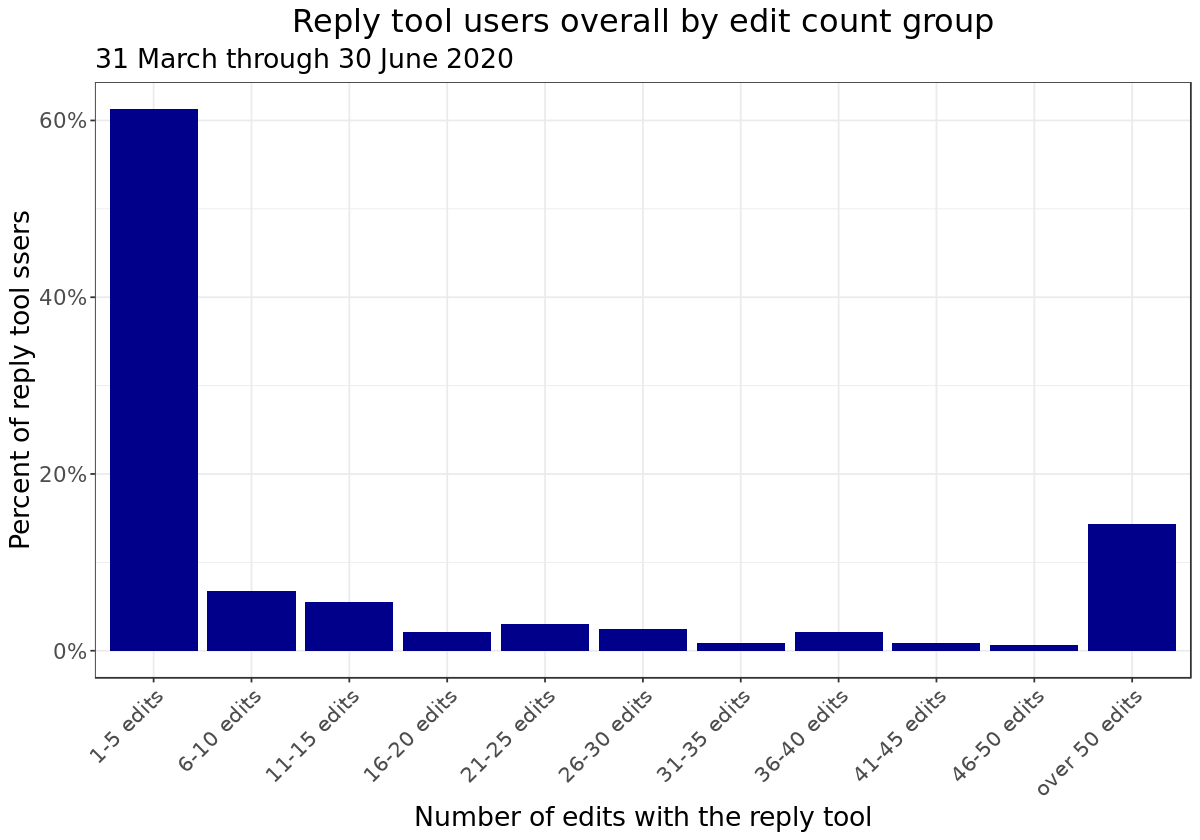

In [373]:
#chart overall users by edit group

options(repr.plot.width = 10, repr.plot.height = 7)

p <- reply_edit_overall_bygroup %>%
    ggplot(aes(x=edit_count_group, y = percent_reply_users)) +
    geom_bar(stat = 'identity', fill = 'darkblue') +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of reply tool ssers",
          x = "Number of edits with the reply tool",
         title = "Reply tool users overall by edit count group",
         subtitle = "31 March through 30 June 2020")  +
     theme_bw() +
   theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
       legend.position = "none") 
 
        
p

In [374]:
ggsave("Figures/reply_edit_users_overall.png", p, width = 16, height = 8, units = "in", dpi = 300)

While the majority of reply tool users make at least 1 edit, not much more make more the 5 edits. Over half (61.28%) of reply tool users made between 1 to 5 edits using the tool. About half of those users are users that made only 1 edit.

32% of reply tool users made more than 10 edits using the tool. 12.2% made between 6 and 15 edits. 

About 14.3% of users made over 50 edits during this timeframe. Note: This might consist of some automated traffic not self-identifed as bots. 

## Number of users that made reply edits by partner wiki

### How many people have made just 1 edit with the Reply Tool by wiki?

In [348]:
# Find overall number of users that made only 1 edit
reply_edits_overall_1edit_bywiki <- reply_edit_users %>%
    group_by(wiki)  %>%
    mutate(total_users = n())  %>%
    filter(reply_edit_count == 1)  %>%
    group_by(wiki, total_users)  %>%
    summarise(one_edit_users = n())  %>%
    mutate(percent_users = one_edit_users/total_users*100)
            

reply_edits_overall_1edit_bywiki 

wiki,total_users,one_edit_users,percent_users
<chr>,<int>,<int>,<dbl>
arwiki,83,29,34.93976
frwiki,153,48,31.37255
huwiki,43,12,27.90698
nlwiki,49,11,22.44898


On a per wiki basis, the percent of reply users that made only 1 edit ranged from about 22% to 35%.  Arabic Wikipedia had the highest number of one edit users while Dutch Wikipedia had the lowest.

### How many people have made edits with the Reply Tool by edit group count?

In [276]:
reply_edit_bywiki<- reply_edit_users %>%
    mutate(edit_count_group = cut(reply_edit_count, breaks = b, labels = names))  %>%
    group_by(wiki, edit_count_group) %>%
     summarise(n_users = n()) %>%
    mutate(percent_reply_users = n_users/sum(n_users))

reply_edit_bywiki

wiki,edit_count_group,n_users,percent_reply_users
<chr>,<fct>,<int>,<dbl>
arwiki,1-5 edits,45,0.542168675
arwiki,6-10 edits,8,0.096385542
arwiki,11-15 edits,5,0.060240964
arwiki,16-20 edits,3,0.036144578
arwiki,21-25 edits,2,0.024096386
arwiki,26-30 edits,2,0.024096386
arwiki,31-35 edits,1,0.012048193
arwiki,over 50 edits,17,0.204819277
frwiki,1-5 edits,102,0.666666667


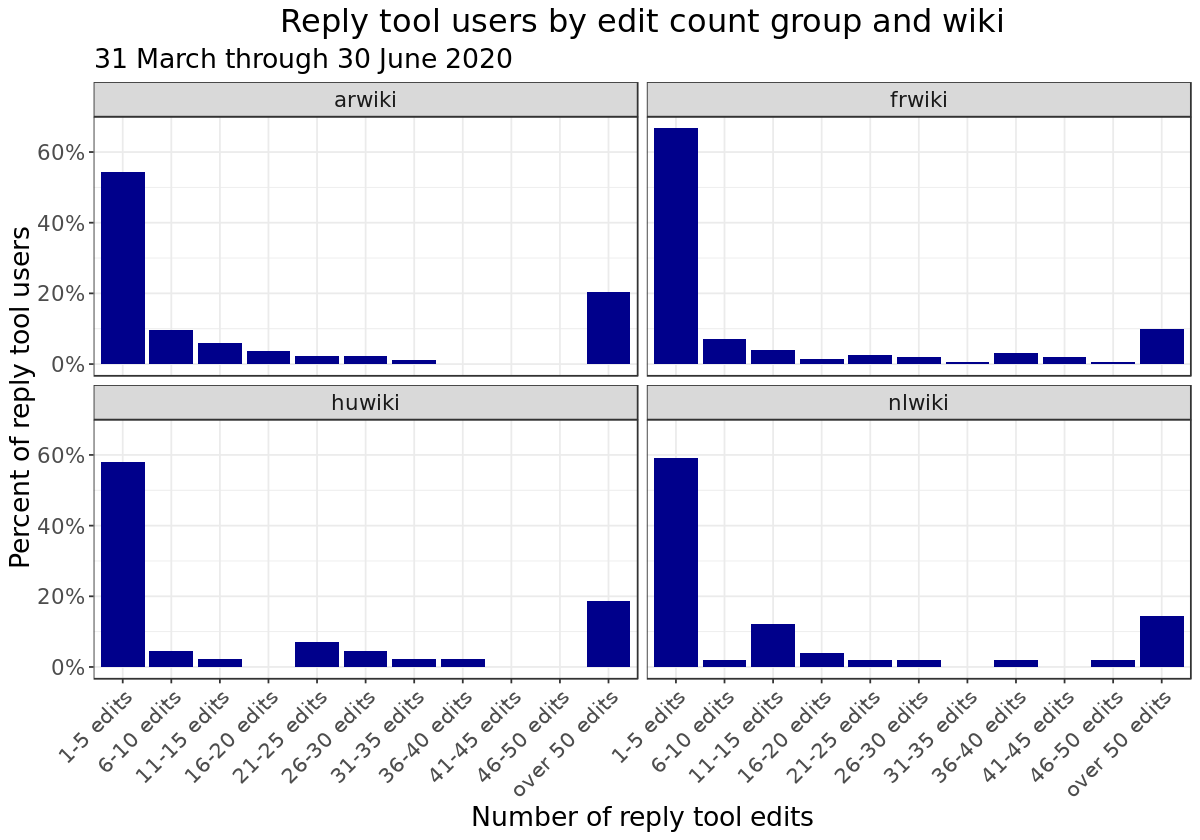

In [369]:
# chart by wiki

p <- reply_edit_bywiki %>%
    ggplot(aes(x=edit_count_group, y = percent_reply_users, fill = edit_count_group)) +
    geom_bar(stat = 'identity', fill = 'darkblue') +
    facet_wrap(~wiki) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of reply tool users",
          x = "Number of reply tool edits",
         title = "Reply tool users by edit count group and wiki",
         subtitle = "31 March through 30 June 2020")  +
     theme_bw() +
    theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
       legend.position = "none") 
 
        
p

In [370]:
ggsave("Figures/reply_edit_users_bywiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

A little over half of all reply users on each partner wiki made between 1-5 edits. After that, there is a general decrase in the numbers of users as the number of edits increase with a couple exceptions.

Dutch Wikipedia has a higher number of users that made 11 to 15 edits compared to 6 to 10 edits.Hungarian Wikipedia had a higher number of users that made between 21 to 25 and 26 to 30 edits compared to 6 to 10 edits.

# How often are people using the Reply tool to make talk page edits?


Notes: 
- We reviewed the number and percentage of people overall that used the tool on just 1 day and that made edits within identified buckets of day (e.g. " E.g. "1-5 days," "6-10 day," etc.)
- Similar to the calculations above, we reviewed data comes from mediawiki_history. We reviewed all edits made with the discussiontools change tag. 
- A distinct day was defined as a distinct calendar day; therefore, some of these edits may have occurred 24 hours apart and some may have occured only a few hours apart depending on what time of day the edit was made; however, it provides a useful estimation of repeat usage of the tool or "stickiness of the tool". 


In [ ]:
query <- "
-- obtain distinct day of edits by user
SELECT
    wiki,
    reply_user,
    COUNT(DISTINCT(day_of_activity)) AS days_of_activity
FROM (
    SELECT
        wiki_db AS wiki,
        event_user_id as reply_user,
        to_date(event_timestamp) as day_of_activity
    FROM wmf.mediawiki_history
    WHERE 
        ARRAY_CONTAINS(revision_tags, 'discussiontools') AND
        snapshot = '2020-06' AND
        event_timestamp >= '2020-03-31' AND 
        event_timestamp <= '2020-06-30' AND
        wiki_db IN ('arwiki','nlwiki', 'frwiki', 'huwiki') AND 
        event_entity = 'revision' AND
        event_type = 'create'
) edits
GROUP BY reply_user, wiki
"

results <- collect(sql(query))
save(results, file="Data/reply_days_activity.RData")

In [279]:
load("Data/reply_days_activity.RData")
reply_days_activity <- results

In [159]:
reply_days_activity$days_of_activity <- factor(reply_days_activity$days_of_activity,levels = 
                                            c("1-5 days", '6-10 days', '11-15 days', 
                                              '16-20 days','21-25 days', '26-30 days',
                                             '31-35 days','36-40 days', '41-45 days','46-50 days', 'over 50 days'))

## Reply users distinct days of activity overall

### How many people edited with the tool on just 1 day?

In [349]:
# Find overall number of users that used the tool on just 1 day
reply_days_overall_1day <- reply_days_activity %>%
    filter(days_of_activity == 1)  %>%
    summarise(one_day_users = n(),
             percent_users = one_day_users/328 *100)

reply_days_overall_1day

one_day_users,percent_users
<int>,<dbl>
127,38.71951


38.72% of all reply users used the tool on just one day; indicating that the majority of users (61.3%) used the tool on two or more days.  

### How many people edited with the Reply Tool by days of activity count?

In [283]:
#Divide days of activity into groups with bin width set to 5 days
b <- c(0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, Inf)
names <- c('1-5 days', '6-10 days', '11-15 days', '16-20 days', '21-25 days', '26-30 days', '31-35 days',
         '36-40 days', '41-45 days', '46-50 days', 'over 50 days')

In [286]:
reply_days_overall_bygroup <- reply_days_activity %>%
    mutate(days_activity_group = cut(days_of_activity, breaks = b, labels = names))  %>%
    group_by(days_activity_group) %>%
    summarise(n_users = n()) %>%
    mutate(percent_reply_users = n_users/sum(n_users))

reply_days_overall_bygroup

days_activity_group,n_users,percent_reply_users
<fct>,<int>,<dbl>
1-5 days,224,0.68292683
6-10 days,29,0.08841463
11-15 days,11,0.03353659
16-20 days,12,0.03658537
21-25 days,9,0.02743902
26-30 days,5,0.01524390
31-35 days,11,0.03353659
36-40 days,5,0.01524390
41-45 days,5,0.01524390


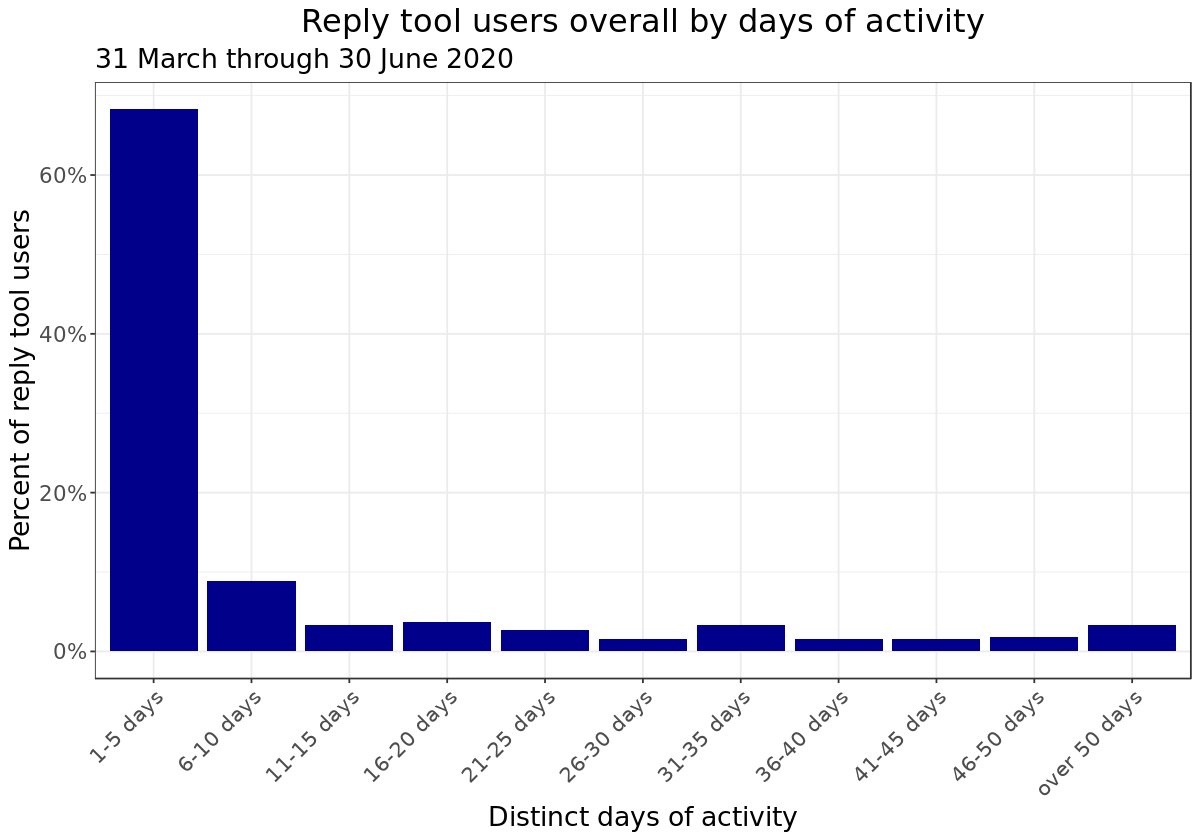

In [371]:
#chart overall users by days of activity group

p <- reply_days_overall_bygroup %>%
    ggplot(aes(x=days_activity_group, y = percent_reply_users)) +
    geom_bar(stat = 'identity', fill = 'darkblue') +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of reply tool users",
          x = "Distinct days of activity",
         title = "Reply tool users overall by days of activity",
         subtitle = "31 March through 30 June 2020")  +
     theme_bw() +
   theme(plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
       legend.position = "none") 
 
        
p

In [372]:
ggsave("Figures/reply_days_activity_overall.png", p, width = 16, height = 8, units = "in", dpi = 300)

68.3% of all reply tool users made an edit between 1 to 5 distinct days. Only about 43.3% of those users made an edit on 1 distinct day so we're seeing the majority of users make an edit between 2 to 5 days. 

The number of users drops generally decreases as the number of distinct days increase with a couple slight fluctuations.

## Reply user distinct days of activity by partner wiki

### How many people edited with the tool on just 1 day by wiki?

In [351]:
# Find overall number of users that made only 1 edit
reply_days_1day_bywiki <- reply_days_activity %>%
    group_by(wiki)  %>%
    mutate(total_users = n())  %>%
    filter(days_of_activity == 1)  %>%
    group_by(wiki, total_users)  %>%  
    summarise(one_day_users = n())  %>%
    mutate(percent_users = one_day_users/total_users*100)
            

reply_days_1day_bywiki

wiki,total_users,one_day_users,percent_users
<chr>,<int>,<int>,<dbl>
arwiki,83,35,42.16867
frwiki,153,62,40.52288
huwiki,43,14,32.55814
nlwiki,49,16,32.65306


Across the partner wikis, the percent of one day users ranges from about 32.65% to 42.17%. Similar to the trends seen for the percent of users that made 1 edit, Arabic Wikipedia had the highed percentage of one days users while Dutch Wikipedia had the lowest.

### How many people edited with the Reply Tool by days of activity count and wiki?

In [294]:
reply_days_bywiki <- reply_days_activity %>%
    mutate(days_activity_group = cut(days_of_activity, breaks = b, labels = names))  %>%
    group_by(wiki, days_activity_group) %>%
    summarise(n_users = n()) %>%
    mutate(percent_reply_users = n_users/sum(n_users))

reply_days_bywiki


wiki,days_activity_group,n_users,percent_reply_users
<chr>,<fct>,<int>,<dbl>
arwiki,1-5 days,55,0.66265060
arwiki,6-10 days,7,0.08433735
arwiki,11-15 days,2,0.02409639
arwiki,16-20 days,2,0.02409639
arwiki,21-25 days,3,0.03614458
arwiki,26-30 days,1,0.01204819
arwiki,31-35 days,4,0.04819277
arwiki,36-40 days,1,0.01204819
arwiki,41-45 days,3,0.03614458


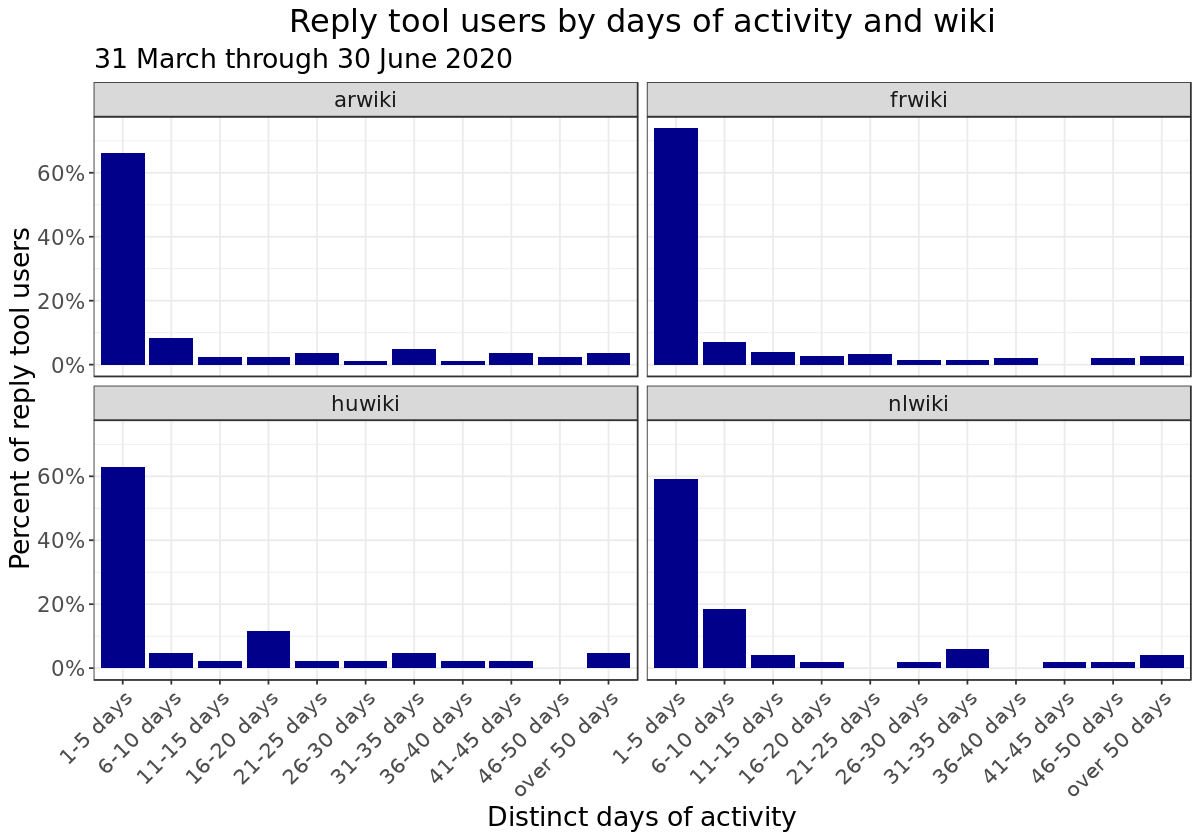

In [376]:
# numbers of days by wiki

p <- reply_days_bywiki %>%
    ggplot(aes(x=days_activity_group, y = percent_reply_users)) +
    geom_col(fill= 'darkblue') +
    scale_y_continuous(labels = percent) +
    facet_wrap(~wiki) +
    labs (y = "Percent of reply tool users",
          x = "Distinct days of activity",
         title = "Reply tool users by days of activity and wiki",
         subtitle = "31 March through 30 June 2020")  +
     theme_bw() +
    theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
       legend.position = "none")  
 
        
p


In [377]:
ggsave("Figures/reply_days_activity_bywiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

On each partner wiki, the majority of reply tool users made their edits between 1 to 5 distinct days. The number of users generally decreases as the number of distinct days increase. A few notable exceptions:
- Hungarian Wikipedia has a higher percentage of users that edited between 16-20 distinct days compared to 6-10 or 11-16 days. 
- Dutch Wikipedia has a larger percentage of users that edited between 6-10 days compared to the other partner wikis.

# How many people have had access to the Reply tool? 

- How many people have explicitly turned on the Discussion Tools Beta Feature?
- How many people had the DiscussionTools Beta Feature turned on for them? 
- How many people have turned off the DiscussionTools Beta Feature? 

## 3a. How many people have explicitly turned on or turned off the Beta Feature? 

### NEW METRICS TO ADD
- How many people explicitly turned the tool on once?
- How many people explicitly turned the tool off once?
- How many distinct people turned off the feature after making at least one edit with the Reply tool?


Notes: 
- Data comes from the PrefUpdate table. We reviewed data available at the time of this analysis from 31 March until June 26th. 
- "Explicitly" indicates users did not have the Automatically enable all new beta features preference checked.
- For this analysis, I counted whenever a user turned on the beta feature (event.value =1) or turned off the beta feature( event.value = 0). Thus, if a user at some point decided to turn it off and on again, we counted them again.
- There are several data QA issues with the PrefUpdate that may impact the results. 
   - There was a drop in pref-update data starting on 2020-05-11 through 2020-06-05. https://phabricator.wikimedia.org/T253151. This is annotated on the figures below.  
    - Analysis assumes that event.value =0 indicates that the beta feature was disabled; however, the isdefualt field is recording false for both event.value = 1 and event.value = 0 properites and disable rate seems off from what is expected. Further investigation is needed.
    - The schema contains multiple identical events for the same preference update https://phabricator.wikimedia.org/T218835. I identified over 100 duplicate events for the discussiontool-betaenable prooerty. 


In [83]:
# Find all users that turned on the beta feature or turned the feature off at least once.  
# Do not count users again if they re-turned it on or off again.
# TODO: Revise to remove any user where beta selection is greater than 1

query <- "
-- find number of opt in or opt outs by beta users
with users AS (
SELECT
    event.userid as user_id,
    wiki,
    event.value as beta_selection,
    Count(*) as n_opt
FROM event.prefupdate 
WHERE 
    event.property = 'discussiontools-betaenable' AND
    wiki IN ('arwiki','nlwiki', 'frwiki', 'huwiki') AND
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) >= '2020-03-31' AND
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) <= '2020-06-30'
GROUP BY
    event.userid,
    wiki,
    event.value
)
--- opt in and opt out limited by those who only do it once
SELECT
    beta.event.userid as user_id,
    beta.wiki,
    CONCAT(year,'-',LPAD(month,2,'0'),'-',LPAD(day,2,'0')) AS date,
    beta.event.value as beta_selection
FROM event.prefupdate AS beta
LEFT JOIN users ON users.user_id = beta.event.userid
WHERE 
    users.n_opt = 1 AND
    beta.event.property = 'discussiontools-betaenable' AND
    beta.wiki IN ('arwiki','nlwiki', 'frwiki', 'huwiki') AND
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) >= '2020-03-31' AND
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) <= '2020-06-30'

"

In [84]:
reply_beta_optins <- wmf::query_hive(query)

In [64]:
reply_beta_optins$date <- as.Date(reply_beta_optins$date, format = "%Y-%m-%d")

In [65]:
#event.value of 1 is equal to a user opt-in
reply_beta_optins$beta_selection <- ifelse(reply_beta_optins$beta_selection == '\"1\"', "opt_in", "opt_out")

## Total Number of Users that Explicilty turned on or turned off the Beta Feature

In [66]:
#Note. We are missing data at end of july so the numbers are likely lower than reported here.
n_optins_total <- reply_beta_optins %>%
    group_by(beta_selection)%>%
    summarise(n_opt_total = sum(n_opt))
    
n_optins_total

beta_selection,n_opt_total
<chr>,<int>
opt_in,1154
opt_out,4052


We recorded a total of 1,154 users that turned on the beta feature at least once since deployed on March 31 through June 30, 2019. We unfortunately missing data from 05 May 2020 through 2020 June 05 so this is likely an underestimate of the total number of users that enabled the feature. 

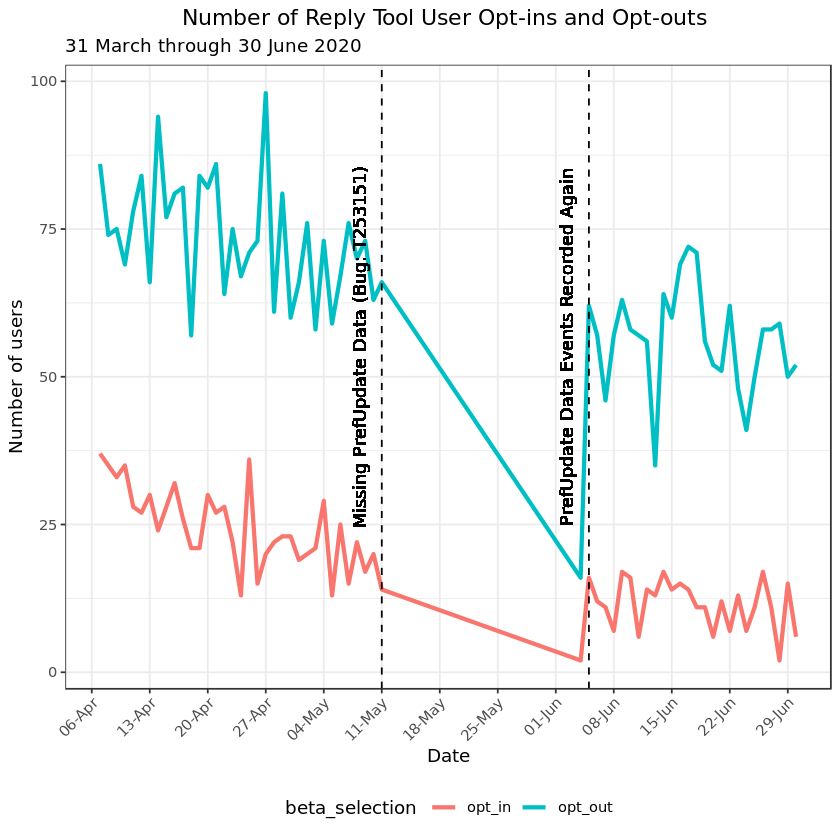

In [69]:
# Chart opt in and opt out rate over time
# Note: There was a drop in pref-update data starting on 2020-05-11 through 2020-06-05	
# https://phabricator.wikimedia.org/T253151
p <- reply_beta_optins %>%
    group_by(date, beta_selection)  %>%
    summarise(n_opt = sum(n_opt)) %>%
    ggplot(aes(x= date, y = n_opt, color = beta_selection)) +
    geom_line(size = 1.2) +
    geom_vline(xintercept = as.Date(c('2020-05-11', '2020-06-05')),
             linetype = "dashed", color = "black") +
  geom_text(aes(x=as.Date('2020-05-11'), y=55, label="Missing PrefUpdate Data (Bug: T253151)"), size=3.7, vjust = -1.2, angle = 90, color = "black") +
  geom_text(aes(x=as.Date('2020-06-05'), y=55, label="PrefUpdate Data Events Recorded Again"), size=3.7, vjust = -1.2, angle = 90, color = "black") +
    scale_x_date(date_labels = "%d-%b", date_breaks = "1 week", minor_breaks = NULL) +
    labs (y = "Number of users",
          x = "Date",
         title = "Number of Reply Tool User Opt-ins and Opt-outs ",
         subtitle = "31 March through 30 June 2020")  +
     theme_bw() +
   theme(legend.position = "bottom",
        axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5)) 
 
        
p


In [70]:
ggsave("Figures/reply_optin_rate.png", p, width = 16, height = 8, units = "in", dpi = 300)

## Number of Users that explicilty turned on or turned off the Beta Feature By Wiki

In [71]:
# review opt-ins by wiki
n_optins_bywiki <- reply_beta_optins %>%
    filter(beta_selection == 'opt_in') %>%
    group_by(wiki)%>% 
    summarise(n_opt_in = sum(n_opt)) 


n_optins_bywiki

wiki,n_opt_in
<chr>,<int>
arwiki,275
frwiki,704
huwiki,58
nlwiki,117


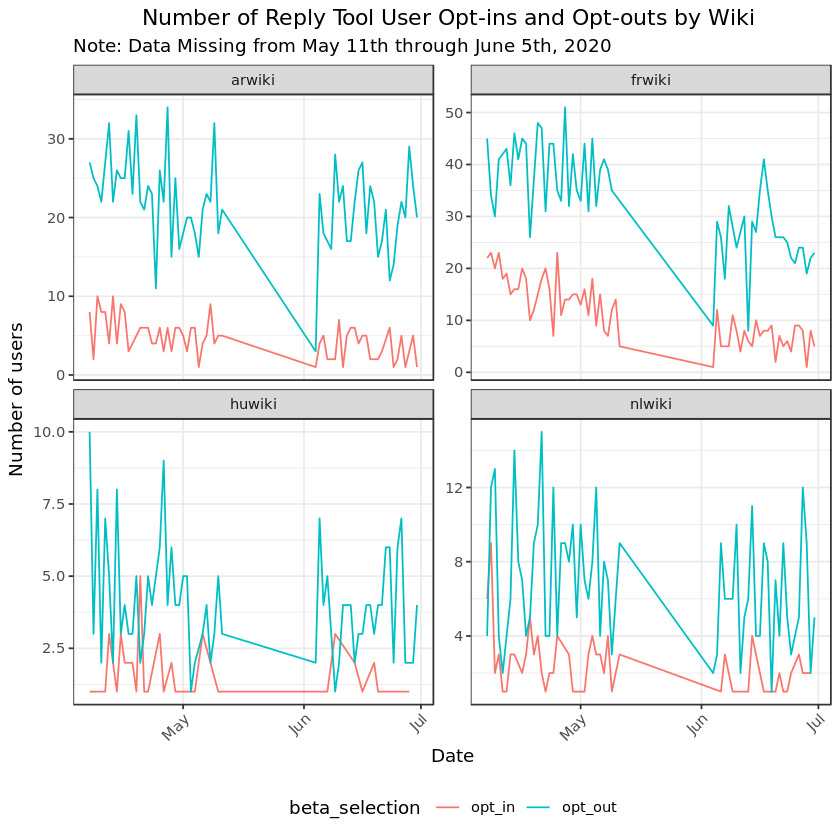

In [72]:
# Chart opt in rate by wiki

p <- reply_beta_optins %>%
    group_by(date, wiki, beta_selection)  %>%
    summarise(n_opt = sum(n_opt)) %>%
    ggplot(aes(x= date, y = n_opt, color = beta_selection)) +
    geom_line() +
    facet_wrap(~wiki, scales = "free_y") +
    scale_x_date(date_labels = "%b", date_breaks = "1 month", minor_breaks = NULL) +
    labs (y = "Number of users",
          x = "Date",
         title = "Number of Reply Tool User Opt-ins and Opt-outs by Wiki ",
         subtitle = "Note: Data Missing from May 11th through June 5th, 2020")  +
     theme_bw() +
   theme(legend.position = "bottom",
        axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5)) 
 

           
p

In [73]:
ggsave("Figures/reply_optin_rate_bywiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

It looks like there are several duplicate events in PrefUpdate. I checked the number of duplicates to confirm the impact. There are 100 events that have been copies for discussiontools-betaenable. I updated the open phab task [T218835](https://phabricator.wikimedia.org/T218835) to document the identified bug. 

In [334]:
query <-"SELECT event.property AS property, COUNT(*) AS duplicated_events
FROM (
  SELECT event, COUNT(*) AS copies
  FROM event.prefupdate 
  WHERE 
    event.property = 'discussiontools-betaenable' AND
    wiki IN ('arwiki','nlwiki', 'frwiki', 'huwiki') AND
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) >= '2020-03-31' AND
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) <= '2020-06-26'
  GROUP BY event
  HAVING copies > 1) AS events
GROUP BY event.property
ORDER BY property LIMIT 10000;"

In [335]:
reply_beta_duplicate_events <- wmf::query_hive(query)

In [336]:
head(reply_beta_duplicate_events)

,property,duplicated_events
,<chr>,<int>
1,discussiontools-betaenable,100


This is a relatively large number of duplicates but it appears that most of the duplicate values but shouldn't signficantly impact the overall trends indicated by the data which indicate that the the opt-in and opt-out rate for the discussion tool has stablized after an initial overall decrease. 

## How many people had the DiscussionTools Beta Feature turned on for them?


 Notes: 
 - "Turned on for them": Indicates users had the following preference checked: Automatically enable all new beta features.
 - Data comes from the mediawiki [user properties](https://www.mediawiki.org/wiki/Manual:User_properties_table/en) table, where property is equal to 'betafeatures-auto-enroll'.
 - Data represents total numbers of users that have set this preference as of June 29th, 2020. 
 - Analysis in separate python notebook (auto_beta_users_collect.ipynb)

|        | Number of Auto Enrolled Beta Users | 
|--------|--------------|
| arwiki | 9927         | 
| nlwiki | 1274         | 
| frwiki | 8170         | 
| huwiki | 558          | 

# How many people should we expect to try the Replying feature when it is turned on as an opt out user preference at our four partner wikis?

 Notes:
 - Data from mediawiki_history.
 - We reviewed the latest 30 days available at the time of analysis: 1-31 March 2020.

In [147]:
## Upper bound: number of people who have made at least 1 edit, 
## in any namespace, in the previous 30 day period
query <- "
    SELECT
    wiki,
    count(*) AS n_editors
FROM (
    SELECT
        event_user_id as user_id,
        wiki_db AS wiki,
        max(size(event_user_is_bot_by) > 0 or size(event_user_is_bot_by_historical) > 0) as bot_by_group,
        COUNT(*) as edits
    FROM wmf.mediawiki_history
    WHERE
        event_timestamp >= '2020-05-01' AND 
        event_timestamp <= '2020-05-31' AND
        event_entity = 'revision' AND
        event_type = 'create' AND
        wiki_db IN ('arwiki','nlwiki', 'frwiki', 'huwiki') AND
        snapshot = '2020-05' AND
        event_user_id != 0
    GROUP BY 
        event_user_id,
        wiki_db
) edits
WHERE
    not bot_by_group 
GROUP BY 
    wiki"

In [148]:
upper_bound_editors <- wmf::query_hive(query)

In [151]:
## Lower bound: number of people who have made at least 1 edit 
##in a talk namespace in the previous 30 day period
query <- "
    SELECT
    wiki,
    count(*) AS n_editors
FROM (
    SELECT
        event_user_id as user_id,
        wiki_db AS wiki,
        max(size(event_user_is_bot_by) > 0 or size(event_user_is_bot_by_historical) > 0) as bot_by_group,
        COUNT(*) as edits
    FROM wmf.mediawiki_history
    WHERE
        event_timestamp >= '2020-05-01' AND 
        event_timestamp <= '2020-05-31' AND
        event_entity = 'revision' AND
        event_type = 'create' AND
        page_namespace_historical % 2 == 1 AND
        wiki_db IN ('arwiki','nlwiki', 'frwiki', 'huwiki') AND
        snapshot = '2020-05' AND
        event_user_id != 0
    GROUP BY 
        event_user_id,
        wiki_db
) edits
WHERE
    not bot_by_group 
GROUP BY 
    wiki"

In [152]:
lower_bound_editors <- wmf::query_hive(query)

## Expected Users Per Wiki: Upper and Lower Bounds (Based on numbers from 1-31 March 2020)

|        | upper bound | lower bound |
|--------|-------------|-------------|
| arwiki | 7,996       | 1,896       |
| nlwiki | 4,804       | 758         |
| frwiki | 22,727      | 3,945       |
| huwiki | 2,201       | 445         |

# How many talk page edits are being made with the Reply Tool?

Of the people who have made at least one edit with the Reply tool, how many of these people have made >5%, >10%, >25% and >50% - of their total talk page edits during the identified time period using the tool?

Notes:
- Data comes from mediawiki_history. 
- Reply tool edits: Any edit marked by discussiontool change tag. 
- Talk Page edits: Any edit made in any of the talk pages.
- This metric has some slight noise as there could be cases where the following people end up looking the same in the data. In this case, both Person A and Person B would end up in the >50% bucket: Person A: made a total two edits to talk pages, one of which was with the Reply tool; Person B: made a total of 150 talk page edits, 75 of which were with the Reply tool.
- There are a couple cases where there are reply edits were recorded but no talk page edits marked for the user. I removed these for this analysis but further investigation is needed. 

In [ ]:
# Obtain reply edits and total talk edits 
# In terminal
# spark2R --master yarn --executor-memory 2G --executor-cores 1 --driver-memory 4G

query <- "
-- obtain all users who have made at least 1 edit with the reply tool

with reply_users AS(
SELECT
    event_user_id AS reply_user,
    wiki_db AS reply_wiki
FROM wmf.mediawiki_history
WHERE 
    ARRAY_CONTAINS(revision_tags, 'discussiontools') AND
    snapshot = '2020-06' AND
    event_timestamp >= '2020-03-31' AND 
    event_timestamp <= '2020-06-31' AND
    wiki_db IN ('arwiki','nlwiki', 'frwiki', 'huwiki') AND NOT
    ARRAY_CONTAINS(event_user_groups_historical, 'bot') AND
    event_entity = 'revision' AND 
    event_type = 'create' 
)
-- obtain user talk and reply counts
SELECT
    user,
    wiki,
    SUM(CAST(reply_edit as int)) as reply_edits,
    SUM(CAST(talk_edit as int)) as talk_edits
FROM (
    SELECT
        event_user_id as user,
        wiki_db AS wiki,
        array_contains(revision_tags, 'discussiontools') as reply_edit,
        page_namespace_historical % 2 == 1 as talk_edit
    FROM
        wmf.mediawiki_history
    WHERE
        event_timestamp >= '2020-03-31' AND 
        event_timestamp <= '2020-06-30' AND
        event_entity = 'revision' AND
        event_type = 'create' AND
        wiki_db IN ('arwiki','nlwiki', 'frwiki', 'huwiki') AND
        snapshot = '2020-06' AND NOT
        ARRAY_CONTAINS(event_user_groups_historical, 'bot')  
) edits
RIGHT JOIN 
    reply_users ON edits.user = reply_users.reply_user AND
    edits.wiki = reply_users.reply_wiki
GROUP BY user, wiki
"


results <- collect(sql(query))
save(results, file="Data/prop_reply_edits.RData")

In [310]:
load("Data/prop_reply_edits.RData")
prop_reply_edits <- results

In [312]:
prop_reply_edits_clean <- prop_reply_edits %>%
    group_by(user, wiki) %>%
    mutate(pct_reply = reply_edits/talk_edits * 100)

In [314]:

#Divide reply edits int0 edit count groups with bin width set to 5 edits
b <- c(0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
names <- c('1-10 percent', '11-20 percent', '21-30 percent', '31-40 percent', '41-50 percent', 
           '51-60 percent', '61-70 percent', '71-80 perent', '81-90 percent', '90-100 percent')

prop_reply_edits_clean <- prop_reply_edits %>%
    group_by(user, wiki) %>%
    mutate(pct_reply = reply_edits/talk_edits * 100,
           reply_prop_group = cut(pct_reply, breaks = b, labels = names)) 

## Overall proportion of user talk page edits made with reply tool 

### Proportion of user talk page edits made with reply tool that are under 5 percent

In [354]:
# Find overall number of users that made under 5 percent of talk page edits with the reply tool
prop_reply_overall_5percent <- prop_reply_edits_clean %>%
    mutate(under_5_percent = ifelse(pct_reply < 5.0, 'True', 'False')) %>% 
    group_by(under_5_percent) %>% 
    filter(under_5_percent == 'True') %>% 
    summarise(n_users = n(),
             percent_users = n_users/328 *100)  

prop_reply_overall_5percent

under_5_percent,n_users,percent_users
<chr>,<int>,<dbl>
True,59,17.9878


Only about 18% of the reply tool users made under 5 percent of their talk page edits during the time period using the reply tool.


### Proportion of user talk page edits made with reply tool by percent group

In [320]:
# table of totals

prop_reply_overall_bygroup <- prop_reply_edits_clean %>%
    filter(!is.na(reply_prop_group)) %>% # a couple cases where there is a reply edit but not talk edit
    group_by(reply_prop_group) %>%
    summarise(n_users = n()) %>%
    mutate(percent_reply_users = n_users/sum(n_users))

prop_reply_overall_bygroup

reply_prop_group,n_users,percent_reply_users
<fct>,<int>,<dbl>
1-10 percent,98,0.31210191
11-20 percent,44,0.14012739
21-30 percent,31,0.09872611
31-40 percent,37,0.11783439
41-50 percent,30,0.09554140
51-60 percent,10,0.03184713
61-70 percent,10,0.03184713
71-80 perent,9,0.02866242
81-90 percent,8,0.02547771


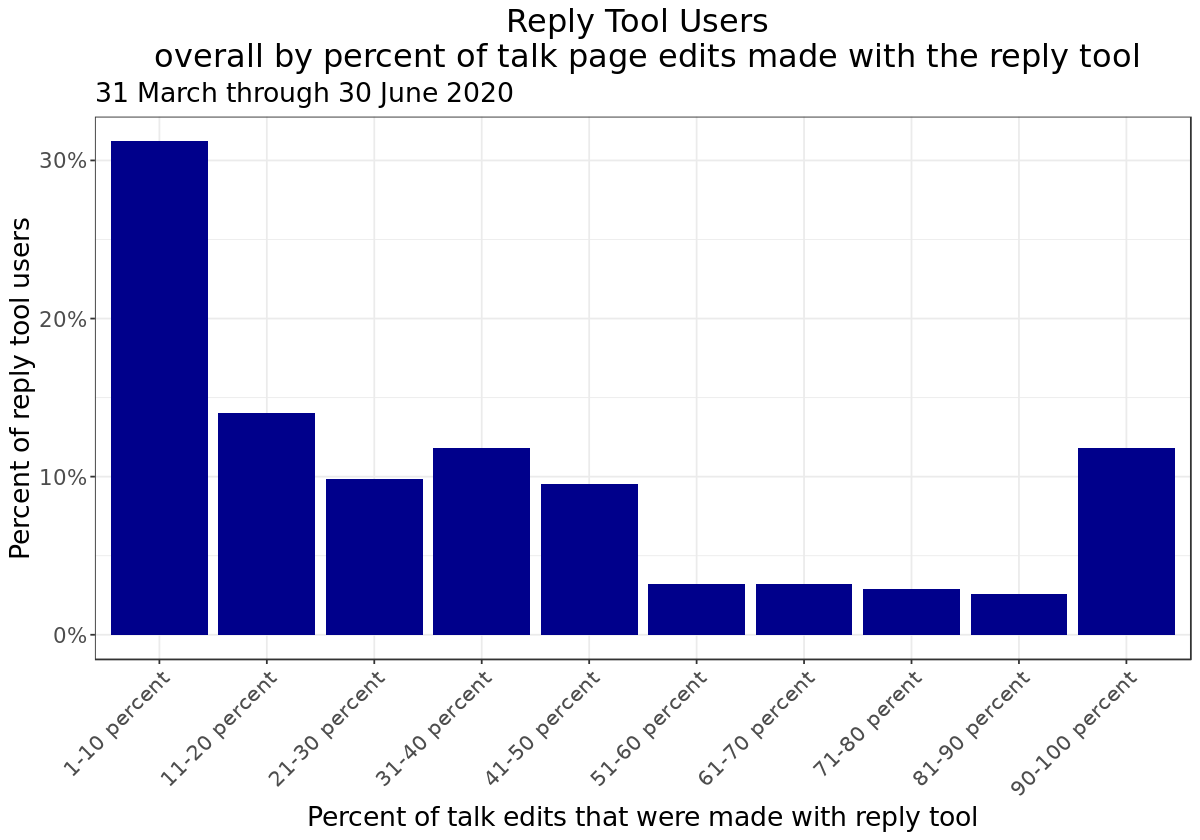

In [378]:
#chart overall users by group

p <- prop_reply_overall_bygroup %>%
    ggplot(aes(x=reply_prop_group, y = percent_reply_users)) +
    geom_bar(stat = 'identity', fill = 'darkblue') +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of reply tool users",
          x = "Percent of talk edits that were made with reply tool",
         title =  "Reply Tool Users \n overall by percent of talk page edits made with the reply tool",
         subtitle = "31 March through 30 June 2020")  +
     theme_bw() +
  theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
       legend.position = "none")
 
        
p

In [379]:
ggsave("Figures/prop_reply_edits_overall.png", p, width = 16, height = 8, units = "in", dpi = 300)

The numbers of users is much more evenly distributed acorss the identified bins compared to the number of edits and number of days metrics.

31% of reply tool users made between 1 to 10 percent of their talk page edits using the reply tool.
23.6% of reply tool users made over half of their talk page edits using the reply tool (76.4% made under 50% of their talk page edits using the reply tool)

## Proportion of talk page edits made with reply tool by wiki

### Proportion of user talk page edits made with reply tool that are under 5 percent by wiki

In [359]:
# Find number of users that made under 5 percent of talk page edits with the reply tool by wiki
prop_reply_bywiki_5percent <- prop_reply_edits_clean %>%
    group_by(wiki)  %>%
    mutate(total_users = n()) %>%
    filter(pct_reply < 5.0) %>% 
    group_by(wiki, total_users) %>%
    summarise(under_5percent_users = n()) %>%
    mutate(percent_users = under_5percent_users/total_users*100) 
 
prop_reply_bywiki_5percent




wiki,total_users,under_5percent_users,percent_users
<chr>,<int>,<int>,<dbl>
arwiki,83,11,13.25301
frwiki,155,32,20.64516
huwiki,44,7,15.90909
nlwiki,49,9,18.36735


The proportion of reply users that made under 5 percent of their talk page edits with the reply tool ranged from 13.25% on Arabic Wikipedia to 20.65% on French Wikipedia. 

### Proportion of user talk page edits made with reply tool by percent group and wiki

In [328]:
# table per wiki

prop_reply_edits_bywiki <- prop_reply_edits_clean %>%
    filter(!is.na(reply_prop_group)) %>% # a couple cases where there is a reply edit but not talk edit
    group_by(wiki, reply_prop_group) %>%
    summarise(n_users = n()) %>%
    mutate(percent_reply_users = n_users/sum(n_users))
    

prop_reply_edits_bywiki

wiki,reply_prop_group,n_users,percent_reply_users
<chr>,<fct>,<int>,<dbl>
arwiki,1-10 percent,21,0.26250000
arwiki,11-20 percent,15,0.18750000
arwiki,21-30 percent,8,0.10000000
arwiki,31-40 percent,11,0.13750000
arwiki,41-50 percent,8,0.10000000
arwiki,51-60 percent,3,0.03750000
arwiki,61-70 percent,2,0.02500000
arwiki,71-80 perent,2,0.02500000
arwiki,90-100 percent,10,0.12500000


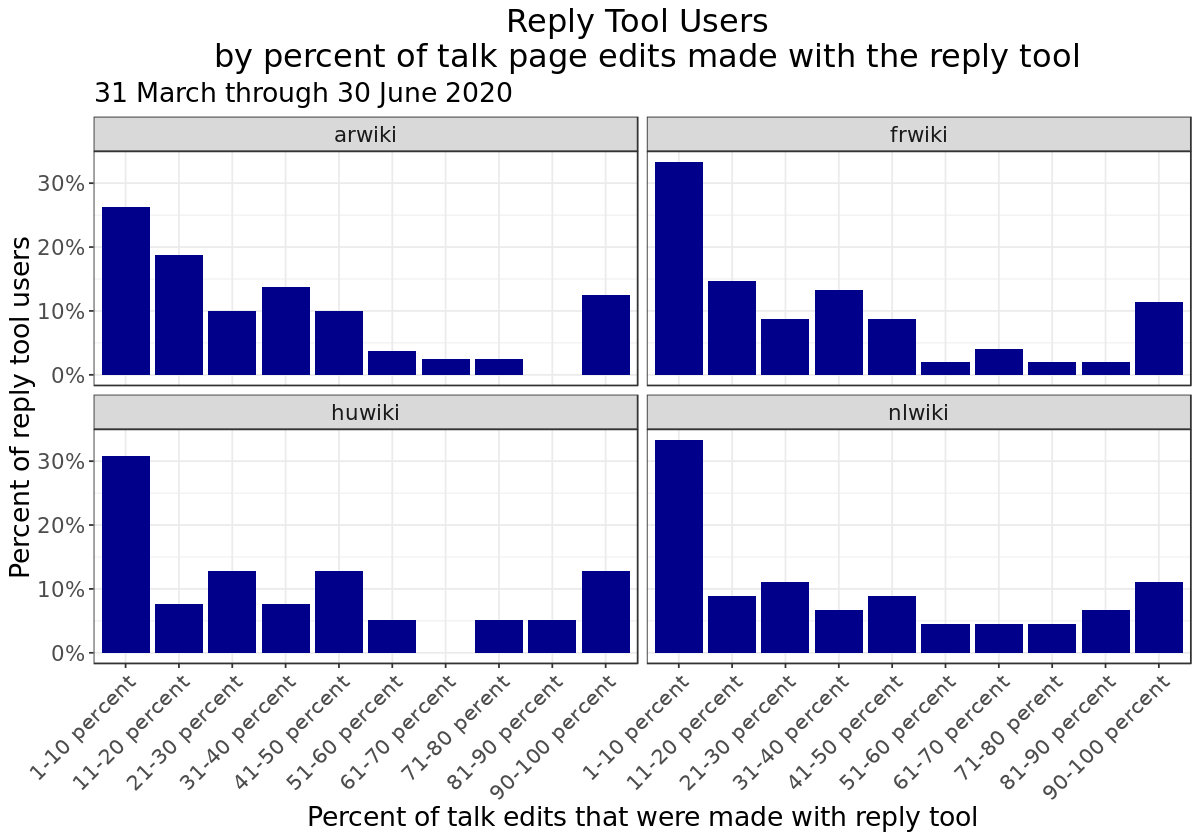

In [380]:
# graph of per wiki numbers

p <- prop_reply_edits_bywiki %>%
    ggplot(aes(x=reply_prop_group, y = percent_reply_users)) +
    geom_col(fill = 'darkblue') +
    facet_wrap(~wiki) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of reply tool users",
          x = "Percent of talk edits that were made with reply tool",
         title = "Reply Tool Users \n by percent of talk page edits made with the reply tool",
         subtitle = "31 March through 30 June 2020")  +
     theme_bw() +
   theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
       legend.position = "none")
 
        
p

In [381]:
ggsave("Figures/prop_reply_edits_bywiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

French and Dutch Wikipedia had the highest percentage of reply users that made between 1 to 10 percent of their edits using the reply tool.

Arabic Wikipedia had the highest percentage of reply users that made between 11 to 20 percent of thier edits using the reply tool.

# What is the experience of Reply Tool Users? In Progress

of the people who have made ≥1 edit with the Reply tool how many total talk page edits have they made since creating their account? Buckets: <10 total talk page edits, 10-100 talk page edits, 100-500 talk page edits, >500 talk page edits.

[Task](https://phabricator.wikimedia.org/T257252)